# DS3000 Day 18

Nov 15 2022

Admin:
- Qwickly attendance
- Project **current state:**
    - Example Final Report posted to Canvas
    - Final Report **due by start of class Dec. 2**
    - Presentation video **due by start of class Dec. 2**
        - Maximum 8 minutes, to allow for questions after
        - All group members must speak during presentation
- HW 7 **Due Friday Nov. 18**

Content:
- Continue Regression

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

## Let's Start with One Last Simple Linear Regression Example

Use the `evdataset.csv` from the Homework module on Canvas. Let us see if we can use linear regression to predict an electric vehicle's `Top Speed` (in kilometers per hour)  based on `Acceleration` (in seconds (time to go from 0 to 100 Km per hr)).

1. Use `LinearRegression()` to fit the data and `reg.predict(x)` to get the `y_pred` predictions
    - Use cross validation with 10 fold to get the predictions
2. Use `r2_score()` to calculate cross validated $R^2$ and interpret it
3. Use the full data set to get the slope and intercept and `show_fit()` to plot the graph, display the best fit line and MSE
    - Interpret the slope in the context of the problem
4. Check the three assumptions of independence, constant variance, and normality for the full data fit
5. Make a recommendation on next steps; can we use this model to predict an EV's Top Speed? Should we try something else? Give up?


In [2]:
df_ev = pd.read_csv('evdataset.csv', index_col='id')
df_ev.head()

,Drive,Acceleration,Top Speed,Electric Range,Total Power,Total Torque,Battery Capacity,Charge Speed,Length,Width,Height,Wheelbase,Gross Weight
id,,,,,,,,,,,,,
1647,Rear,7.8,185,390,168,350,77.4,49,4515,1890,1580,2900,2495
1493,AWD,6.2,160,330,215,520,69.7,46,4684,1834,1701,2829,2580
1229,AWD,3.2,260,415,500,850,93.4,46,4963,1966,1381,2900,2880
1252,Rear,5.7,190,470,250,430,83.9,54,4783,1852,1448,2856,2605
1534,Rear,7.9,160,450,150,310,82.0,55,4261,1809,1568,2771,2300


In [3]:
n_splits = 10

x = np.array(df_ev['Acceleration']).reshape(-1, 1)
y = np.array(df_ev['Top Speed'])

kfold = KFold(n_splits=n_splits)

reg = LinearRegression()

y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    reg = reg.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = reg.predict(x_test)

In [4]:
r2_score(y_true=y, y_pred=y_pred)

0.7571696748778166

75.7% of the variability in Top Speed can be explained by Acceleration.

In [5]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

def show_fit(x, y, slope, intercept):
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    # for each data point plot the error
    for idx, (x_i, y_i) in enumerate(zip(x, y)):
        plt.plot([x_i, x_i], [y_i, slope * x_i + intercept], 
                 ls='--', lw=3, color='tab:red',
                 label='error' if idx == 0 else "")
    
    plt.legend()
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.2f}, MSE = {mse:.3f}, R2 = {r2_score(y, y_pred):.2f}')

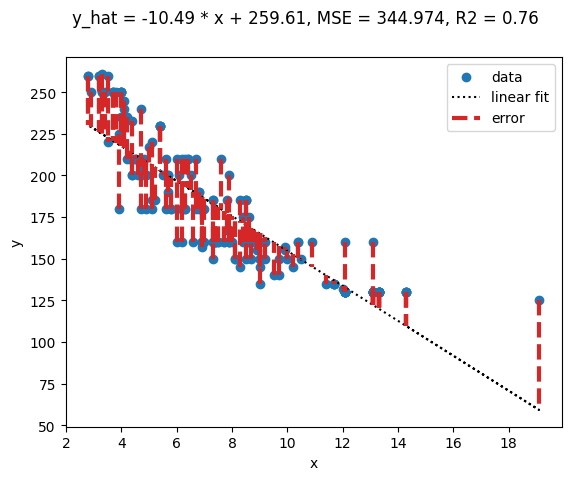

In [6]:
reg = LinearRegression()

reg.fit(x, y) 

# get the slope
slope = reg.coef_[0]

# get the intercept
intercept = reg.intercept_

y_pred = reg.predict(x) # same as y_pred = slope * x + intercept

show_fit(x, y, slope, intercept)

The slope can be interpreted as for every additional second it takes an EV to reach 100 km/hr, the Top Speed of the EV decreases by 10.49 km/hr.

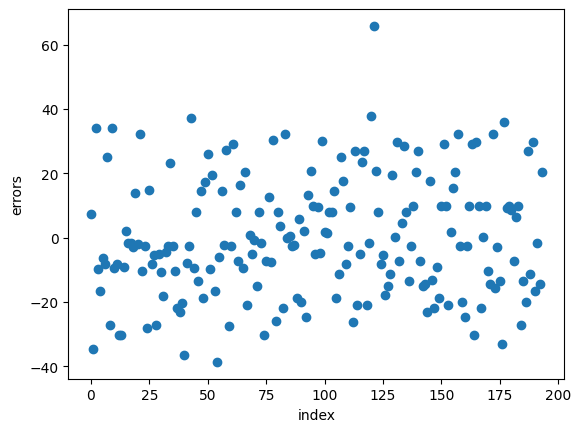

In [7]:
# check independence
errors = y - y_pred
plt.scatter(x = range(len(y)), y = errors)
plt.xlabel('index')
plt.ylabel('errors');

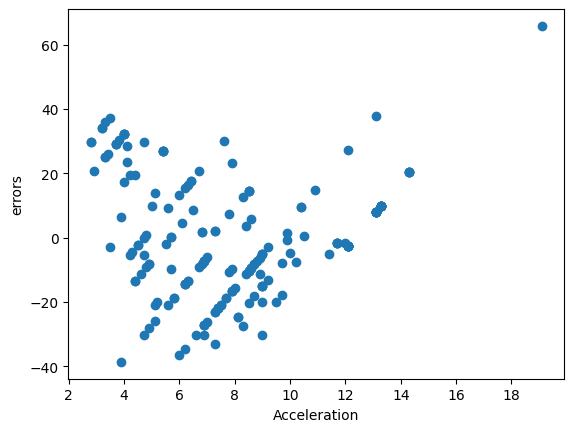

In [8]:
# check constant variance
plt.scatter(x = x, y = errors)
plt.xlabel('Acceleration')
plt.ylabel('errors');

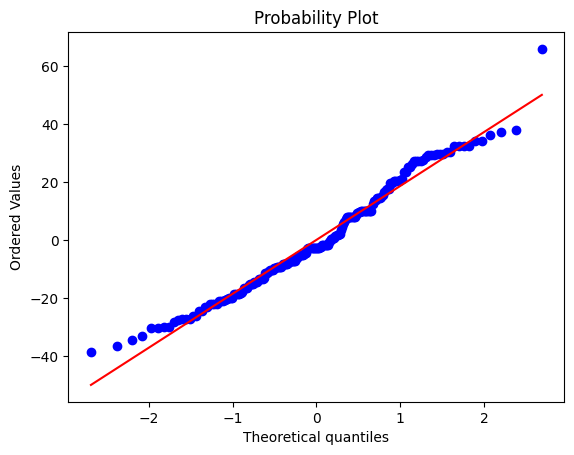

In [9]:
# check normality
stats.probplot(errors, dist="norm", plot=py)
py.show()

Independence and normality look fairly well met, but constant variance does not. In fact, there is some curving to the errors, which suggests there is another feature that impacts Top Speed which we are not accounting for. This should lead us to examine moving to a multiple and/or polynomial regression framework.

# Multiple Regression (using more than one x to predict a single y)

How can we predict Top Speed using more than a single variable?

    Top Speed = b_0 + b_1 * Acceleration + b_2 * Electric Range + b_3 * Total Power
    
Lets write a function `disp_regress()` which:
- Takes the `df`, `x_feat_list`, `y_feat` as arguments and returns a regression object
    - does not bother with cross validation yet
- **note:** we no longer need to `.reshape(-1, 1)` as was done in single feature case

In [10]:
df_ev.head()

,Drive,Acceleration,Top Speed,Electric Range,Total Power,Total Torque,Battery Capacity,Charge Speed,Length,Width,Height,Wheelbase,Gross Weight
id,,,,,,,,,,,,,
1647,Rear,7.8,185,390,168,350,77.4,49,4515,1890,1580,2900,2495
1493,AWD,6.2,160,330,215,520,69.7,46,4684,1834,1701,2829,2580
1229,AWD,3.2,260,415,500,850,93.4,46,4963,1966,1381,2900,2880
1252,Rear,5.7,190,470,250,430,83.9,54,4783,1852,1448,2856,2605
1534,Rear,7.9,160,450,150,310,82.0,55,4261,1809,1568,2771,2300


In [11]:
def disp_regress(df, x_feat_list, y_feat, verbose=True):
    """ linear regression, displays model w/ coef
    
    Args:
        df (pd.DataFrame): dataframe
        x_feat_list (list): list of all features in model
        y_feat (list): target feature
        verbose (bool): toggles command line output
        
    Returns:
        reg (LinearRegression): model fit to data
    """
    # initialize regression object
    reg = LinearRegression()

    # get target variable
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    if verbose:
        # print model  
        model_str = y_feat + f' = {reg.intercept_:.2f}'
        for feat, coef in zip(x_feat_list, reg.coef_):
            model_str += f' + {coef:.2f} {feat}'
        print(model_str)

        # compute / print r2
        r2 = r2_score(y_true=y, y_pred=y_pred)
        print(f'r2 = {r2:.3}')
    
    return reg

In [12]:
# should be same as before (except R2 is not cross validated, so slightly better)
disp_regress(df_ev, x_feat_list = ['Acceleration'], y_feat = 'Top Speed')

Top Speed = 259.61 + -10.49 Acceleration
r2 = 0.761


LinearRegression()

In [13]:
disp_regress(df_ev, x_feat_list = ['Acceleration', 'Electric Range', 'Total Power'], y_feat = 'Top Speed')

Top Speed = 145.88 + -3.19 Acceleration + 0.05 Electric Range + 0.19 Total Power
r2 = 0.892


LinearRegression()

## Adding more features to your model ...

- does not decrease $R^2$
    - occasionally this means we may not be able to trust $R^2$, if we add a feature that is misleading to the model
    - we can instead use $Adjusted R^2$, which penalizes based on how many features we include
- can confuse the interpretation of your results
    - variance of x features impacts magnitude of coefficients
        - could scale, but then interpretation of slopes is not intuitive anymore
    - there is another way to assess feature importance: `RandomForestRegressor`

In [14]:
import statsmodels.api as sm

# another way to fit the regression model
X, y = df_ev[['Acceleration', 'Electric Range', 'Total Power']], df_ev['Top Speed']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

#display line and regular R2 (to verify same as before) and adjusted R-squared
print(model.params)
print(model.rsquared)
print(model.rsquared_adj)

const             145.880087
Acceleration       -3.194005
Electric Range      0.045939
Total Power         0.192806
dtype: float64
0.8915409087849577
0.8898283968184044


Note that just because the magnitude of the Acceleration slope is larger than the other two, does not *necessarily* mean that it is more impactful than the other two. To determine feature importance, we can use `RandomForestRegressor`:

Remember that a `RandomForestClassifier` seeks to build nodes which minimize the Gini Coefficient 
- Remember: Gini = 0 when all samples belong to a single class

A `RandomForestRegressor` seeks to build nodes which minimize the **MSE** at each node
- Remember: $MSE=0$ when all observations are estimated exactly

In [15]:
from sklearn.ensemble import RandomForestRegressor

y_feat = 'Top Speed'
x_feat_list = ['Acceleration', 'Electric Range', 'Total Power']

# initialize regression object
rand_forest_regressor = RandomForestRegressor()

# get target variable
x = df_ev.loc[:, x_feat_list].values
y = df_ev.loc[:, y_feat].values

# fit regression
rand_forest_regressor.fit(x, y)

# compute / store r2
y_pred = rand_forest_regressor.predict(x)

# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')

r2 = 0.986


In [16]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Decision Trees)')

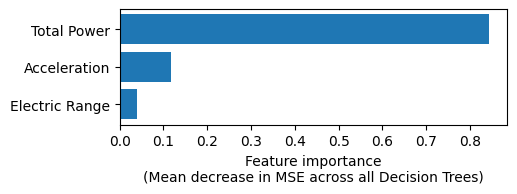

In [17]:
plot_feat_import(x_feat_list, rand_forest_regressor.feature_importances_, limit=10)

## Checking Assumptions in Multiple Regression

Still important, and still much the same, however since we have multiple x features, we need to check multiple plots to assess constant variance/linearity: one for each x feature.

In [18]:
# initialize regression object
reg = LinearRegression()

# get target variable
x = df_ev.loc[:, x_feat_list].values
y = df_ev.loc[:, y_feat].values

# fit regression
reg.fit(x, y)

# compute / store r2
y_pred = reg.predict(x)

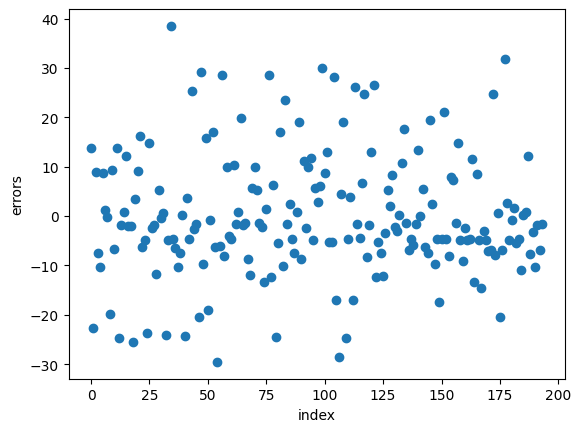

In [19]:
# check independence
errors = y - y_pred
plt.scatter(x = range(len(y)), y = errors)
plt.xlabel('index')
plt.ylabel('errors');

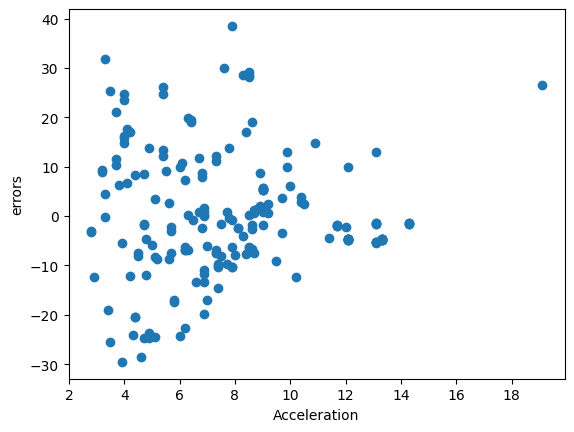

In [20]:
# check constant variance (Acceleration)
plt.scatter(x = x[:,0], y = errors)
plt.xlabel('Acceleration')
plt.ylabel('errors');

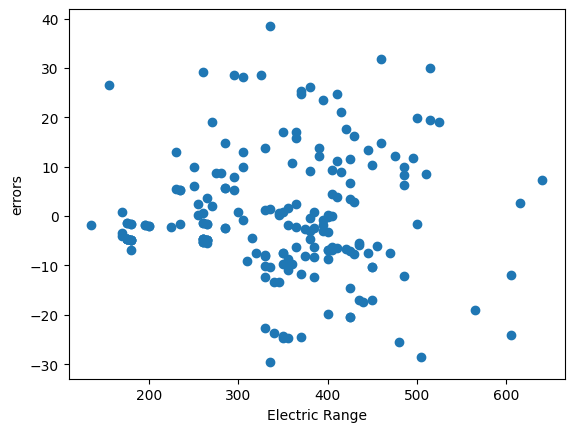

In [21]:
# check constant variance (Electric Range)
plt.scatter(x = x[:,1], y = errors)
plt.xlabel('Electric Range')
plt.ylabel('errors');

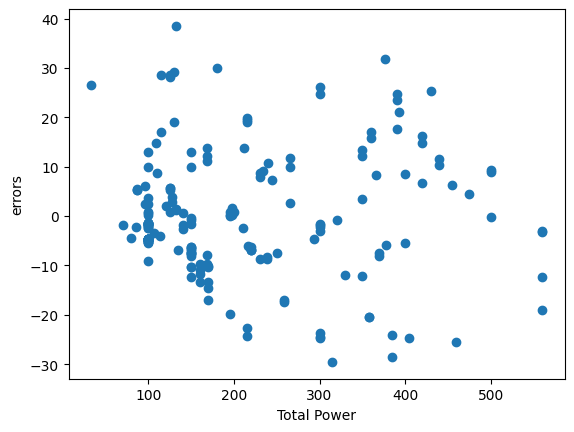

In [22]:
# check constant variance (Total Power)
plt.scatter(x = x[:,2], y = errors)
plt.xlabel('Total Power')
plt.ylabel('errors');

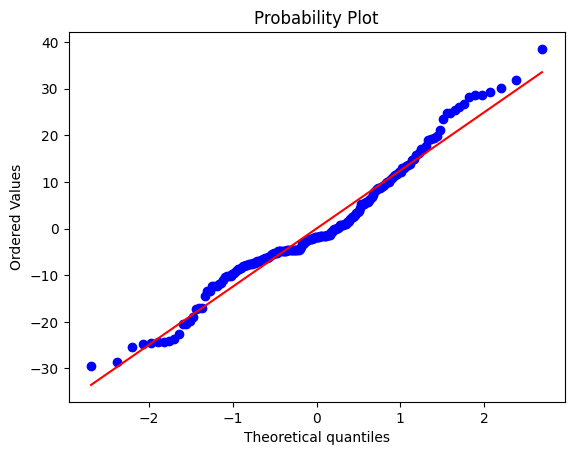

In [23]:
# check normality
stats.probplot(errors, dist="norm", plot=py)
py.show()

# What if we don't want a straight line model?
- exponential regression
- polynomial regression

# Exponential Regression 1

Suppose we want to fit a line to data whose y grows exponentially with x:

$$y = \hat{\beta}_0 e^{b_1 x}$$

## Fitting a straight line doesn't really work well...

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

sns.set(font_scale=1.4)

# this simulates exponential data; don't worry too much about how it works

def get_exp_data(betahat0, b1, n=30, x=None, noise_var=1):
    """ builds x, y with noisy exponential relationship
    
    y = \hat{\beta}_0 e^{b_1 x}
    
    Args:
        alpha0 (float): model param (see above)
        a1 (float): model param (see above)
        n (int): number of samples (default 0 to 1)
        x (np.array): domain to sample
        noise_var (float): variance of noise
        
    Returns:
        x (np.array): input features
        y (np.array): output features
    """
    
    if x is None:
        x = np.linspace(0, 1, n)
        
    # we explicitly build y with the given relationship
    y = betahat0 * np.exp(b1 * x)

    # its unfair to assume that all points fall on this line, in practice
    # our data will be "messy".  we can approximate this by adding noise
    # to the y computed directly above
    np.random.seed(0)
    y = y + np.random.standard_normal(n) * noise_var
    
    # reshape x to sklearn standard (many samples, one feature)
    x = x.reshape(-1, 1)
    
    return x, y

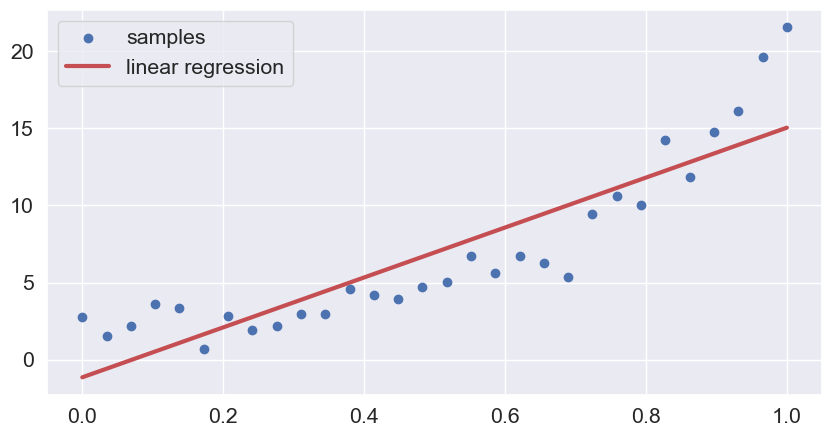

In [25]:
# get exp scatter points
x, y = get_exp_data(betahat0=1, b1=3)

# scatter
plt.scatter(x, y, label='samples')

# build / fit linear model
reg = LinearRegression()

# plot linear model
reg.fit(x, y)
y_hat = reg.predict(x)
plt.plot(x, y_hat, linewidth=3, color='r', label='linear regression')

plt.legend()
plt.gcf().set_size_inches(10, 5)

# Exponential Regression 2

Instead of fitting our observations $(x_j, y_j)$ with the typical linear model:

$$\hat{y} =  b_0 + b_1 x $$

What if we take the log of each $y_j$ first so that we fit $(x_j, \log y_j)$ instead?

Text(0.5, 1.0, 'great linear fit :)')

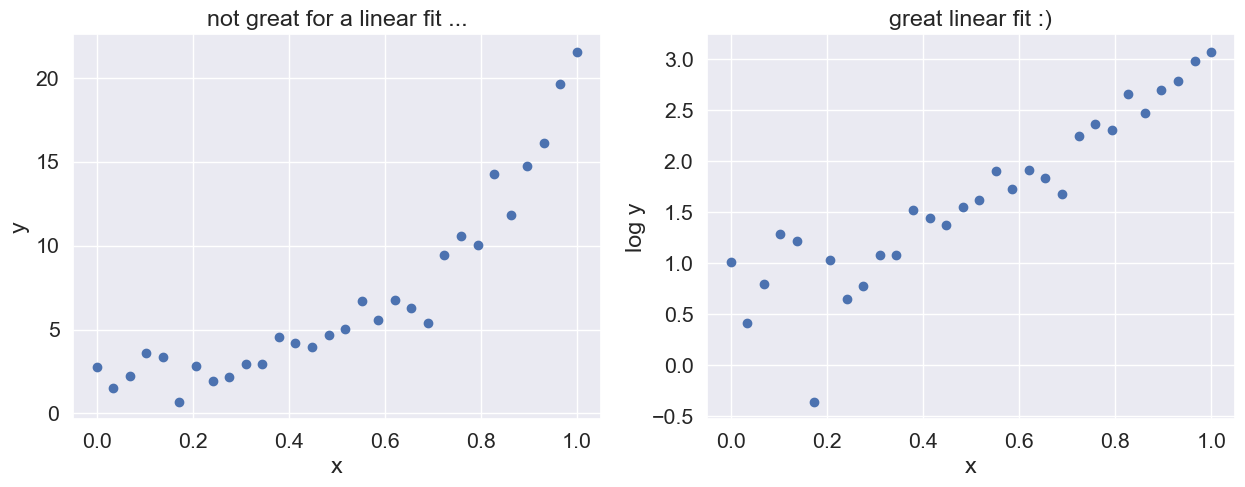

In [26]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

plt.sca(axs[0])
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
axs[0].set_title('not great for a linear fit ...')

plt.sca(axs[1])
plt.scatter(x, np.log(y))
plt.xlabel('x')
plt.ylabel('log y')
axs[1].set_title('great linear fit :)')

## Exponential Regression 3

Algebraically, whats going on here?

$$ \begin{align*}
\log \hat{y} &= b_0 + b_1 x
\\
e^{\log \hat{y}} &= e^{b_0 + b_1 x}
\\
\hat{y} &= \hat{\beta}_0 e^{b_1 x}
\end{align*}$$
where $\hat{\beta}_0 = e^{b_0}$.  

**By modelling log y instead of y directly, we are able to ensure that our "linear" regression gives us an exponential model**

## Expoential Regression: Approach 

- the input y (for training) to the regression must be log y:
    - apply `np.log()` to y before training
- the output of the regression is log y
    - apply `np.exp()` to get y so it is comparable with initial data

## Exponential Regression 4: Implementation

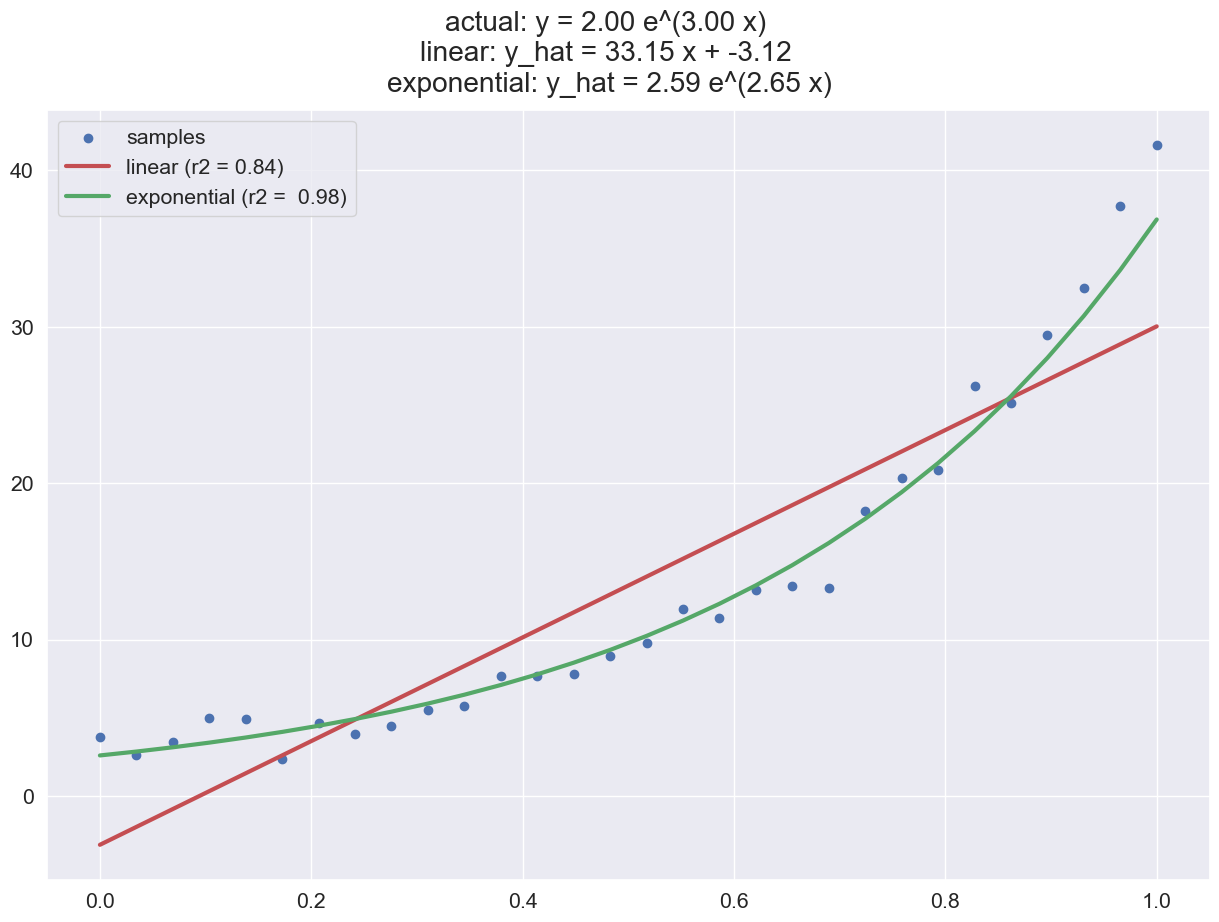

In [27]:
# get exp scatter points
betahat0=2
b1=3
x, y = get_exp_data(betahat0=betahat0, b1=b1)

# scatter
plt.scatter(x, y, label='samples')

# build / fit linear model
reg = LinearRegression()

# plot linear model
reg.fit(x, y)
y_hat = reg.predict(x)
r2_linear = r2_score(y_true=y, y_pred=y_hat)
slope = reg.coef_[0]
intercept = reg.intercept_
plt.plot(x, y_hat, linewidth=3, color='r', label=f'linear (r2 = {r2_linear:.2f})')

# plot exp model
reg.fit(x, np.log(y))            # NOTE: np.log applied (see previous approach slide)
y_hat = np.exp(reg.predict(x))   # NOTE: np.exp applied (see previous approach slide)
r2_exp = r2_score(y_true=y, y_pred=y_hat)
plt.plot(x, y_hat, linewidth=3, color='g', label=f'exponential (r2 = {r2_exp: .2f})')

# extract coefficients and print meaning
b_0_pred = reg.intercept_
b_1_pred = reg.coef_[0]
betahat0_pred = np.exp(b_0_pred)

title = f'actual: y = {betahat0:.2f} e^({b1:.2f} x) \n' + \
        f'linear: y_hat = {slope:.2f} x + {intercept:.2f} \n' + \
        f'exponential: y_hat = {betahat0_pred:.2f} e^({b_1_pred:.2f} x)'
        
plt.legend()
plt.suptitle(title)
plt.gcf().set_size_inches(15, 10)

# When to reach for an exponential model:

The "Math" definition of exponential: 
- growth in proportion to how much currently exists

Examples:
- population
    - animals
    - bacteria
    - covid cases
    - cancer cells
    - weeds in garden
    - fire
- anything growing at an interest rate
    - investments
    - debt

# Lecture Break/Practice 1

For the `2ndmonth_covid_usa.csv` dataset
1. scatter `day` & `total_cases`
    - between February 21 and March 21, 2020
1. fit an exponential model to the data
1. compute / print an r2 value of the exponential model
1. (extra) print a string which shows the model itself


$$ \hat{y} = \hat{\beta}_0 e^{b_1 x} $$

In [28]:
df_covid = pd.read_csv('first_2ndmonth_covid_usa.csv')
df_covid.head()

,iso_code,continent,location,date,day,total_cases
0,USA,North America,United States,2020-02-21,31,16
1,USA,North America,United States,2020-02-22,32,16
2,USA,North America,United States,2020-02-23,33,16
3,USA,North America,United States,2020-02-24,34,16
4,USA,North America,United States,2020-02-25,35,16


# What if we don't want a straight line model?
- ~exponential regression~
- polynomial regression

# Polynomial Regression
We want to find another insight which allows us to perform polynomial regression just as we have done with exponential regression. 

**Polynomial Regression Model:**
$$
y = b_0\cdot x^0 + b_1\cdot x^1 + b_2 \cdot x^2 + ... + b_n \cdot x^n
$$

Before we can approach this problem, lets build a good test case of data which comes from some known polynomial.

## Representing / Computing a Polynomial

In [29]:
def coef_to_poly_str(coef, include_zero=False):
    """ creates a str of polynomial corresponding to coef    

    Args:
        coef (np.array): coefficients of polynomial
        
    Returns:
        poly_str (str): str of polynomial
    """
    
    str_monomial_list = []
    for deg, coef in enumerate(coef):
        if coef == 0 and include_zero == False:
            continue
        str_monomial_list.append(f'{coef:+.1f} x^{deg:d}')
        
    # handle case of all zero coef
    if len(str_monomial_list):
        poly_str = ' '.join(str_monomial_list)
    else:
        poly_str = '0'
        
    return f'y = {poly_str}'

In [30]:
coef_to_poly_str(coef=[1, 9, 0, -1, 123])

'y = +1.0 x^0 +9.0 x^1 -1.0 x^3 +123.0 x^4'

In [31]:
def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    b_0 x^0 + b_1 x^1 + b_2 x^2 + b_3 x^3 + ...
    
    coef = [b_0, b_1, b_2, b_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, b in enumerate(coef):
        y += b * x ** deg
        
    return y 

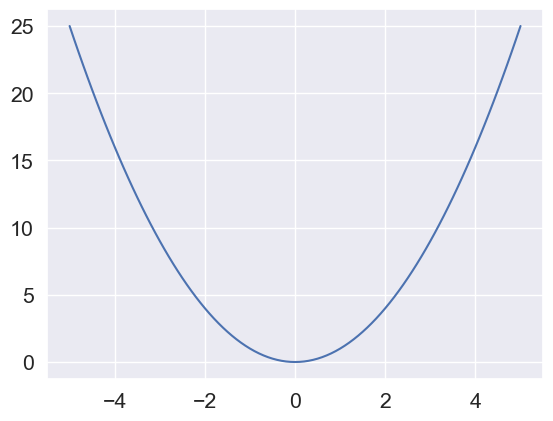

In [32]:
# validate that this works, lets build the polynomial x^2
# x^2 = 0 x^0 + 0 x^1 + 1 x^2 so coef = [0, 0, 1]
x = np.linspace(-5, 5, 101)
coef = np.array([0, 0, 1])
y = poly(x, coef)

# plot a polynomial
plt.plot(x, y);

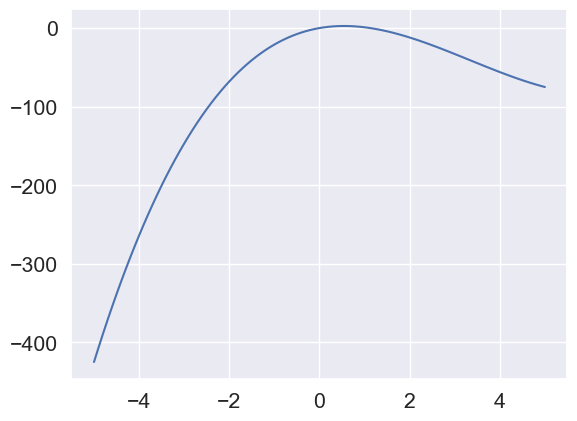

In [33]:
# lets play with a more interesting polynomial
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]
y = poly(x, coef)
plt.plot(x, y);

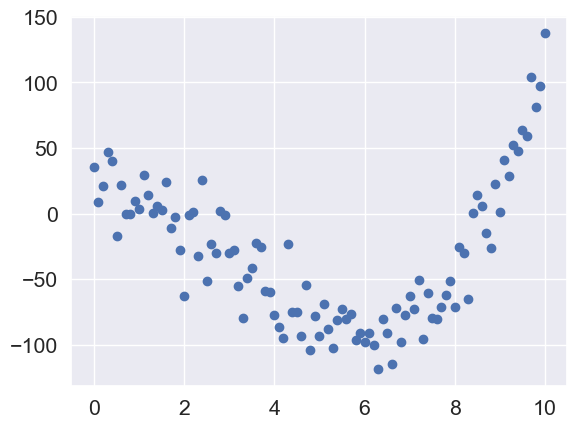

In [34]:
def get_poly_data(coef, x_start=0, x_fin=10, n=101, noise=20):
    np.random.seed(0)
    x = np.linspace(x_start, x_fin, n)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * noise
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

x, y = get_poly_data(coef)
plt.scatter(x, y);

# Polynomial Regression: Approach

#### Polynomial Regression Model:
$$
y = b_0\cdot x^0 + b_1\cdot x^1 + b_2 \cdot x^2 + ... + b_n \cdot x^n
$$

where $x$ refers to the same input feature each time raised to a different power.

#### Multiple Regression Model:
$$
y = b_0\cdot x_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + ... + b_n \cdot x_n
$$

where $x_i$ refer to distinct features.

## "tricking" model into looking at polynomial regression as multiple regression:

What if we "trick" sklearn's Linear Regression into thinking that higher order terms are new features.  That is, we'll set the "new" feature 
- $x_0$ as our single feature x raised the 0th power (always zero)
- $x_1$ as our single feature x raised the 1st power
- $x_2$ as our single feature x raised the 2nd power
- $x_3$ as our single feature x raised the 3rd power

#### What happened to the intercept in the Multiple Regression Model?
- By setting `fit_intercept=False` we have removed the intercept term from the multiple regression model
- $b_0$ multiplies first "feature" $x_0$
    - first "feature" is x raised to the 0th power ... always zero
    - $b_0$ is still the intercept

In [35]:
from sklearn.preprocessing import PolynomialFeatures

x = np.linspace(0, 10, 101)
x = x.reshape(-1, 1)

In [36]:
# examine "raw" features
# right now, x is just an example feature with 101 values from 0 to 10
#x
x[18: 23]

array([[1.8],
       [1.9],
       [2. ],
       [2.1],
       [2.2]])

In [37]:
degree = 4
poly_feat = PolynomialFeatures(degree=degree)
x_poly = poly_feat.fit_transform(x)

# examine polynomial features
x_poly[18:23]

array([[ 1.    ,  1.8   ,  3.24  ,  5.832 , 10.4976],
       [ 1.    ,  1.9   ,  3.61  ,  6.859 , 13.0321],
       [ 1.    ,  2.    ,  4.    ,  8.    , 16.    ],
       [ 1.    ,  2.1   ,  4.41  ,  9.261 , 19.4481],
       [ 1.    ,  2.2   ,  4.84  , 10.648 , 23.4256]])

## Polynomial Regression: Putting it all together

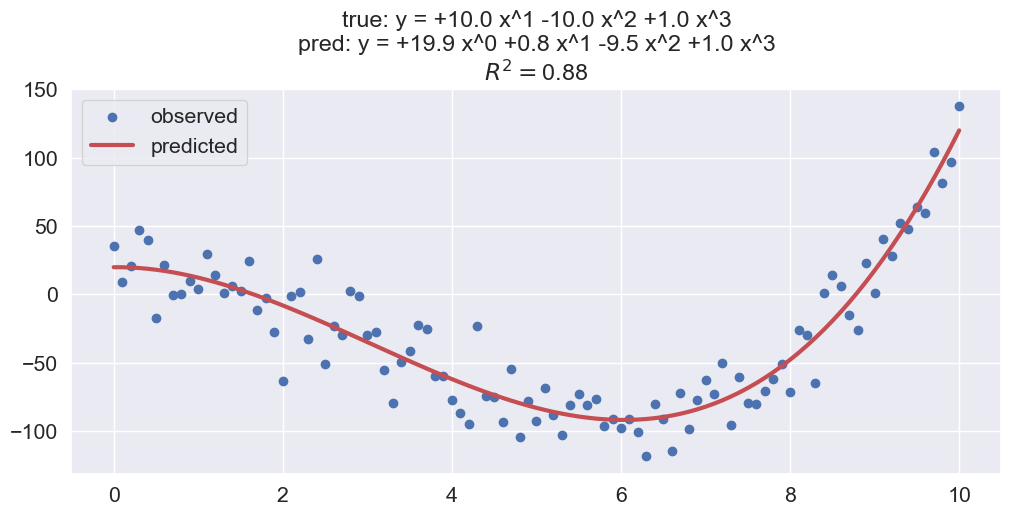

In [38]:
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

# in practice, we can't use the "right" answer (coef above) because we won't know exactly what the true degree is
# we'll revisit this later.  for now, we'll "cheat" by setting
# degree by peeking at proper answer
degree = len(coef) - 1

# get noisy polynomial data
x, y = get_poly_data(coef)

# process x to polynomial features
poly_feat = PolynomialFeatures(degree=degree)
x_poly = poly_feat.fit_transform(x)

# fit polynomial regression
# because our first x-feature is simply 1 we don't fit an intercept (the first coefficient will be the intercept)
reg = LinearRegression(fit_intercept=False)
reg.fit(x_poly, y)

# predict y (from regression)
y_pred = reg.predict(x_poly)

# plot
plt.scatter(x, y, label='observed')
plt.plot(x, y_pred, color='r', linewidth=3, label='predicted')

# collect coefficients
coef_pred = reg.coef_

# getting strs of polynomial (to print)
str_poly_true = coef_to_poly_str(coef)
str_poly_pred = coef_to_poly_str(coef_pred)

plt.title(f'true: {str_poly_true}\npred: {str_poly_pred}\n$R^2=${r2_score(y, y_pred):.2f}')

plt.legend()
plt.gcf().set_size_inches(12, 5)

In [39]:
def fit_plot_poly(x, y, degree):
    """ fits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_samples, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
    
    # fit via linear regression
    reg = LinearRegression(fit_intercept=False)
    reg.fit(x_poly, y)
    
    # predict y values (line of polynomial)
    # (we use 101 evenly spaced points as there may be so few
    # observations that the polynomial appears piecewise linear
    # with straight lines between each observation)
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
    x_fine_poly = poly_project.fit_transform(x_fine)
    y_pred_fine = reg.predict(x_fine_poly)
    
    # compute r2
    y_pred = reg.predict(x_poly)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # get the predicted line
    coef_pred = reg.coef_
    str_poly_pred = coef_to_poly_str(coef_pred)
    
    # plot polynomial / observations
    plt.plot(x_fine, y_pred_fine, label=f'degree {degree} fit', color='k', linewidth=2)
    plt.title(f'pred: {str_poly_pred}\n$R^2=${r2:.2f}')
    plt.scatter(x, y, label='observed', color='r')
    plt.legend()  
    
    return reg

LinearRegression(fit_intercept=False)

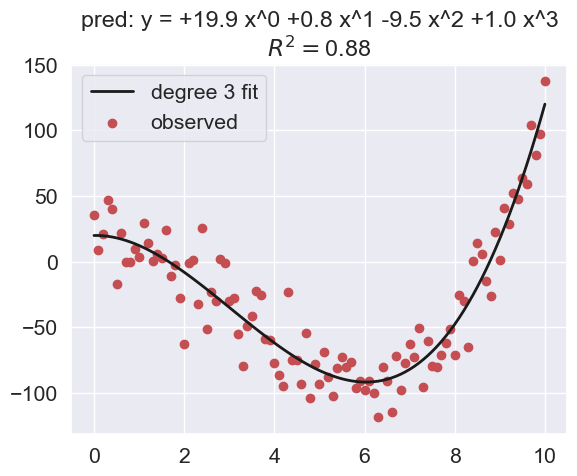

In [40]:
# get noisy polynomial data
x, y = get_poly_data(coef)

#fit_plot_poly(x, y, 0)
#fit_plot_poly(x, y, 1)
#fit_plot_poly(x, y, 2)
fit_plot_poly(x, y, 3)
#fit_plot_poly(x, y, 4)

## In a real problem how do we know what degree to choose?

In our dummy data we "cheated" by looking at the real polynomial, represented by `coef`, to determine what degree we should fit the polynomial with:

```python
# degree: what order polynomial should we fit data with?
degree = len(coef) - 1
```

In practice we won't have this luxury ...

### $R^2$ reminder:
- $R^2=1$ implies the line passes through each observation
- $R^2=0$ when the line "ignores" $x$ and is constant at `np.mean(y)`
    - see `degree=0` above
- $R^2<0$ implies the line does a poorer job than the constant estimate `np.mean(y)`
    - this should be very rare, and is only even possible in multiple/polynomial (not simple) regression

### A good first approach at choosing degree:

**Maybe choosing the polynomial with maximum $R^2$ is a good idea ...**

Spoiler Alert: its not a good idea

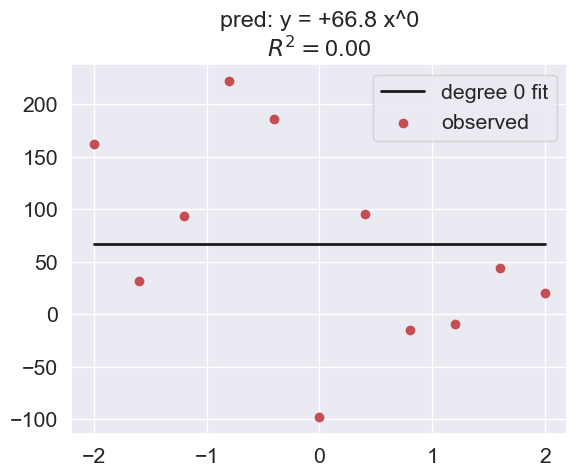

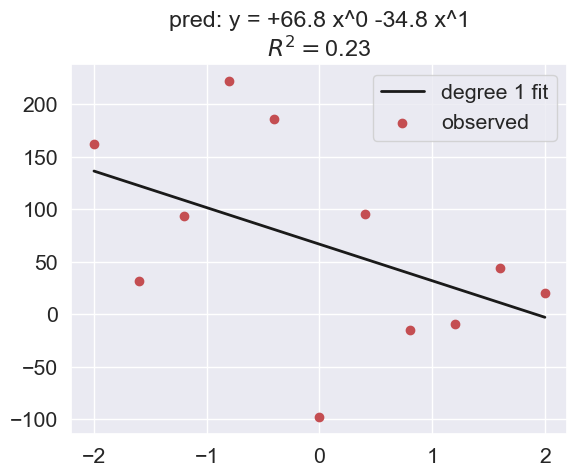

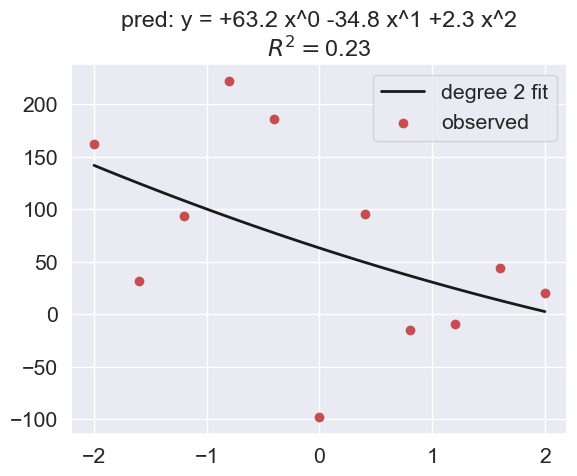

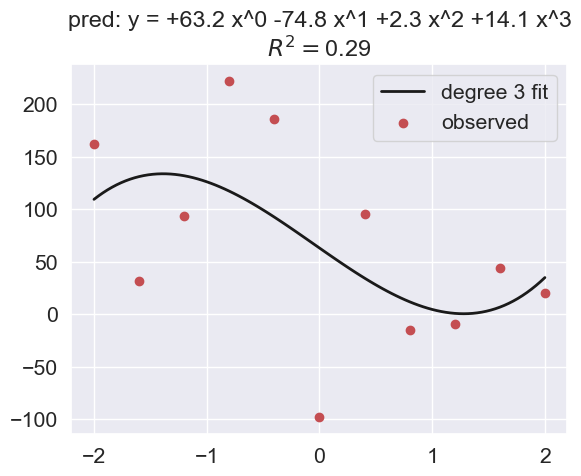

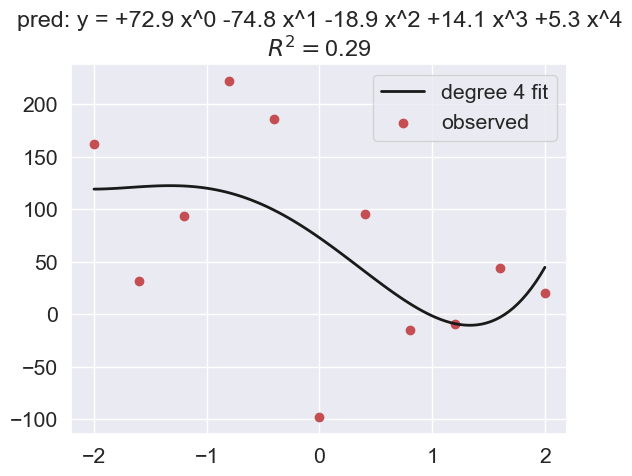

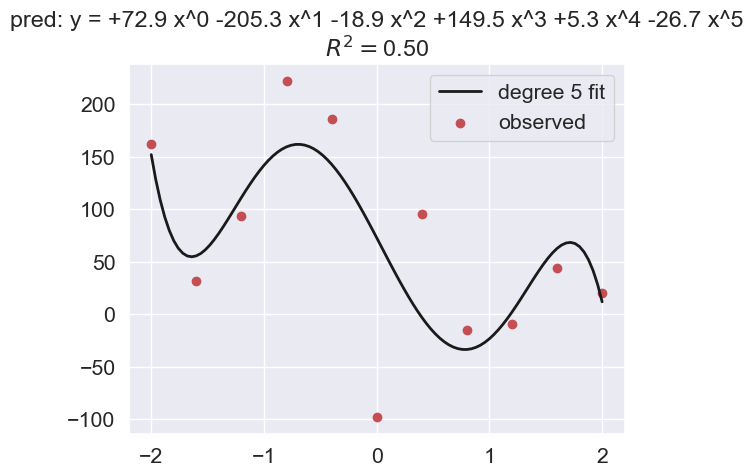

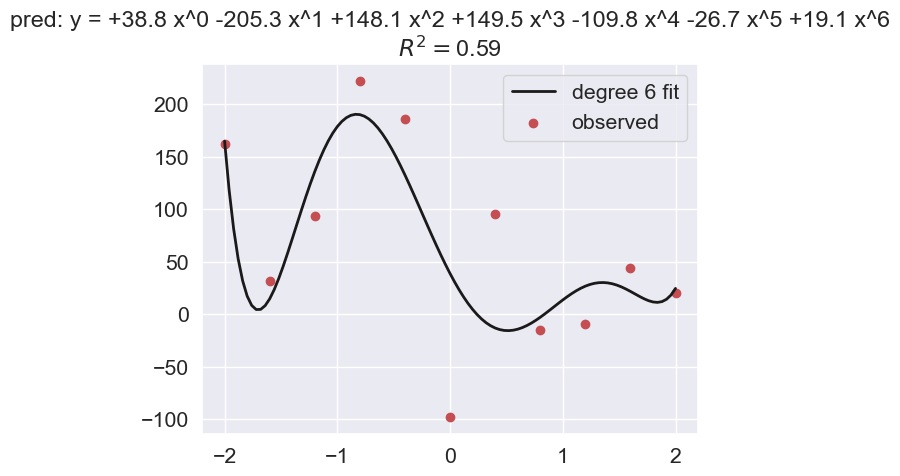

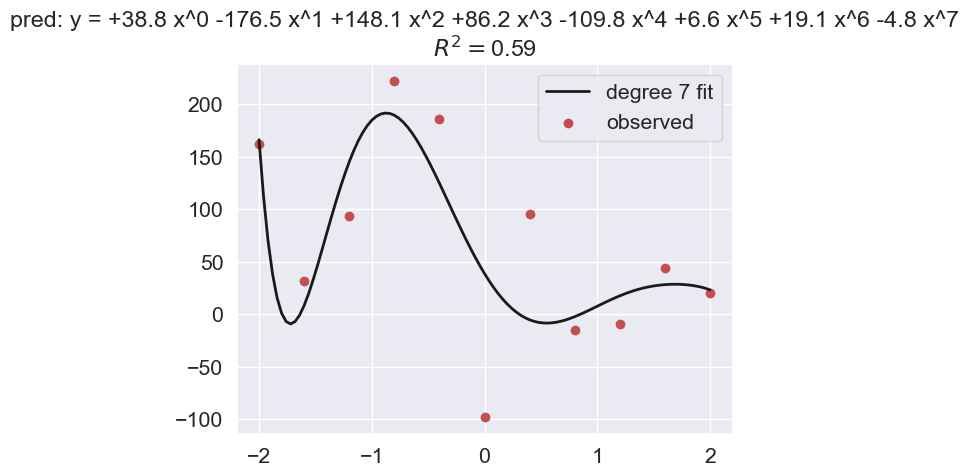

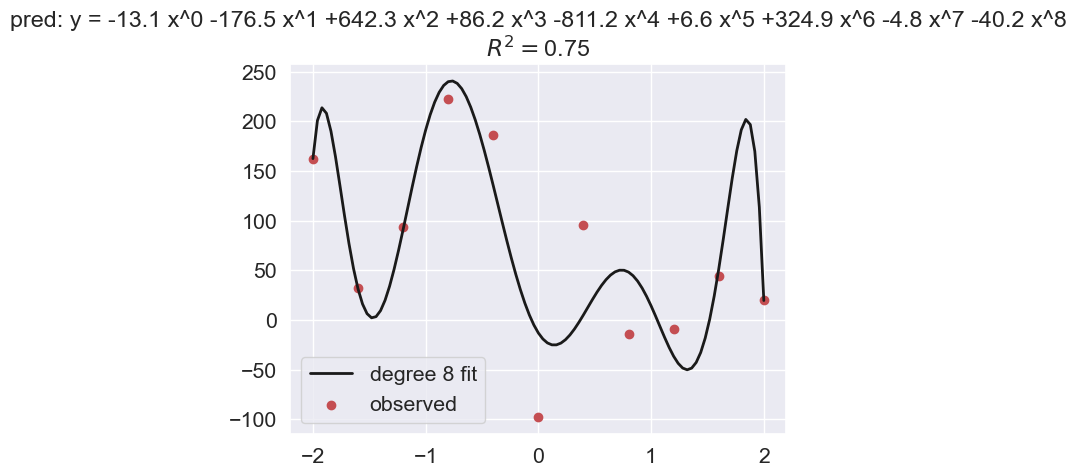

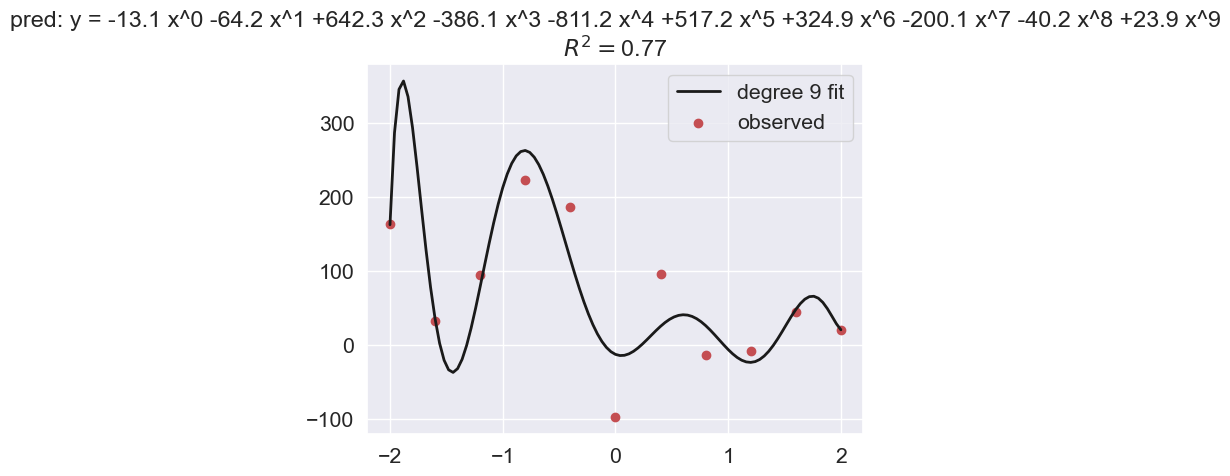

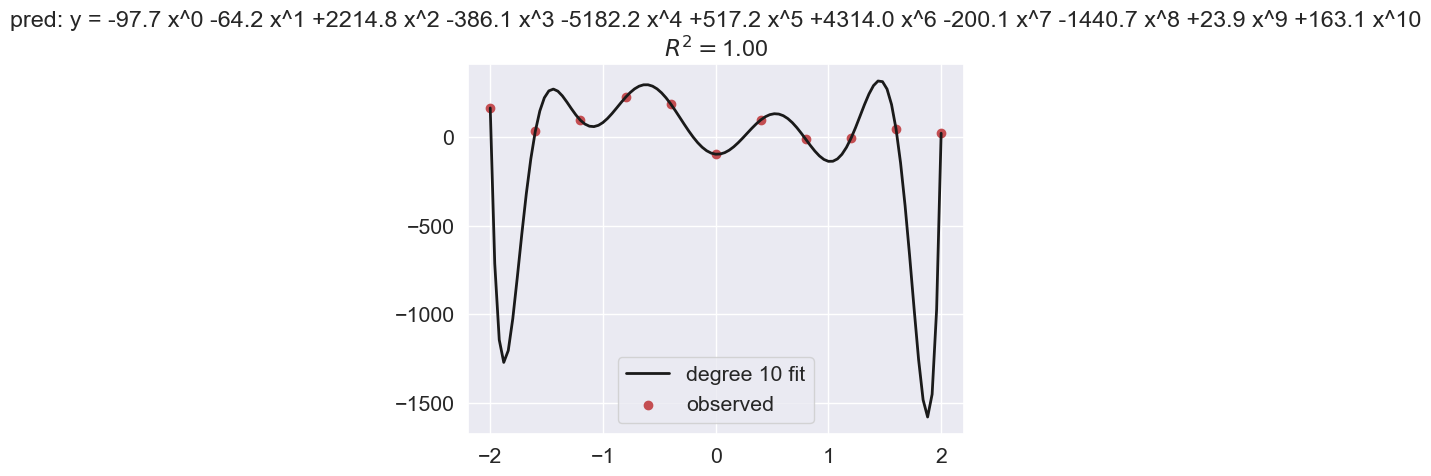

In [41]:
coef = np.array([0, 1, -1, 1])
noise_snr = 100

x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=11, noise=noise_snr)

for degree in range(11):
    # we need a new figure with every plot (so they don't all plot on same figure!)
    plt.figure()

    fit_plot_poly(x, y, degree)

## Takeaway:
**perfect fit:** $R^2 = 1$ and the polynomial touches each sample point

- we can always perfectly fit n points with a polynomial of order n-1.  
    - any 1 point can be fit with a line of form: $\hat{y} = b_0 x^0$
    - any 2 points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1$
    - any 3 points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1 + b_2 x^2$
    - any n points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1 + b_2 x^2 + ... + b_n x^{n-1}$
- increasing polynomial degree will never decrease $R^2$
    - increasing the order is akin to adding feature to the model, these features can never "hurt" the classifier as the corresponding coefficient could be set to zero to remove them if $R^2$ were decreased

# Overfitting: Post-Mortem

What went wrong here?

According to the final model above, we'd predict some new, unseen data point with $x \approx 1.8$ would have an estimate of $\hat{y} \approx -1500$ (this may change based on randomness; make sure to check last plot).

**Overfitting:** When a model (over)fits the given training data in a way which harms performance on some new, unseen datapoint.  

Overfitting is characterized:
- qualitatively
    - the model looks overly complex
        - given these observations, the dip between the final two data points seems too complex
- quantitatively
    - performance on unseen data is lowered
        - we can use cross validation to measure performance on unseen data
            - ...maybe we could pick a polynomial degree this way

# Preventing overfitting:

|                          |                            Underfitting                            |                            Proper fitting                           |                            Overfitting                            |
|:------------------------:|:------------------------------------------------------------------:|:-------------------------------------------------------------------:|:-----------------------------------------------------------------:|
| Training Set Performance |                                 Bad                                |                                 Good                                |                              Too Good                             |
|  Testing Set Performance |                                 Bad                                |                            About as good                            |                                Bad                                |
|     Model Complexity     |                               Simple                               |                         balanced complexity                         |                           Overly complex                          |
|                          | <img src="https://i.ibb.co/sPTY37G/underfit-poly.png" width=250px> | <img src="https://i.ibb.co/HYGHxvm/justright-poly.png" width=250px> | <img src="https://i.ibb.co/sP76DKd/overfit-poly.png" width=250px> |

In many problems, we are building the classifier / regression model to predict new, unseen samples.  Given this:

**"proper fit" is the model which maximizes the performance on a testing set (e.g. cross validated accuracy or cross validated $R^2$)**

In [42]:
def cross_val_r2(x, y, degree, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)
    
    """
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
        
    # initialize empty y predictions
    y_pred = np.empty_like(y)
    
    # initialize linear regression model
    # fit_intercept=False since we're using poly features
    reg = LinearRegression(fit_intercept=False)
    
    kfold = KFold(n_splits=n_splits)
    for train_idx, test_idx in kfold.split(x_poly, y):
        # split data
        x_poly_test = x_poly[test_idx, :]
        x_poly_train = x_poly[train_idx, :]
        y_train = y[train_idx]
        
        # fit
        reg.fit(x_poly_train, y_train)
        
        # predict
        y_pred[test_idx] = reg.predict(x_poly_test)
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

LinearRegression(fit_intercept=False)

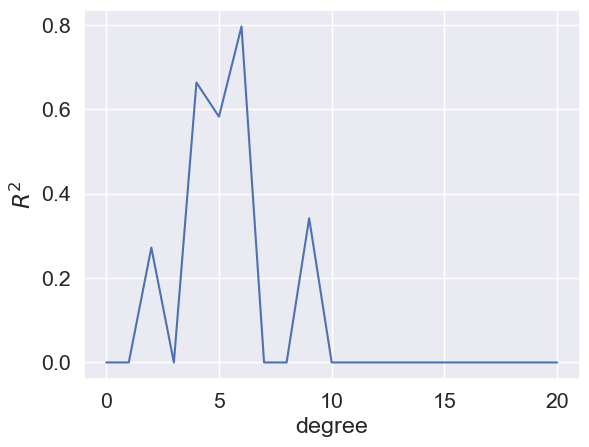

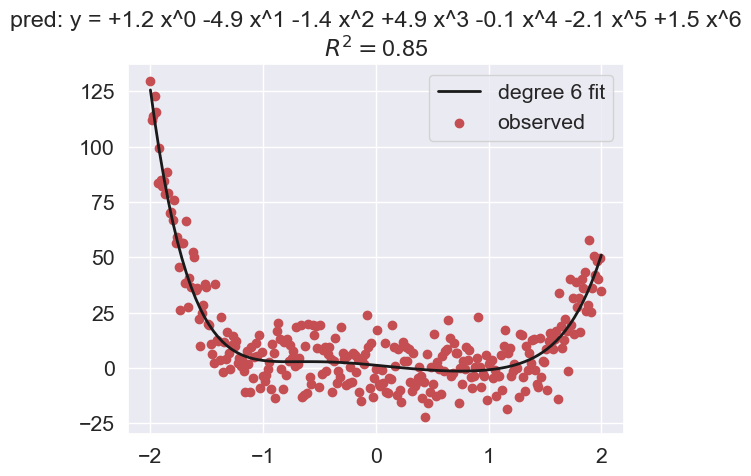

In [43]:
coef = np.array([0, 0, 0, 0, 1, -1, 1])
noise_snr = 10

# sample noisy data from polynomial
x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=301, noise=noise_snr)

# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(21):
    r2 = cross_val_r2(x, y, degree)
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)
# r2_per_degree = np.array(r2_per_degree)

    
plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')

plt.figure()
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(x, y, degree_best)

## With EV Data

In our initial fit with `Acceleration` predicting `Top Speed` one of the error plots suggested that the relationship might not be linear:

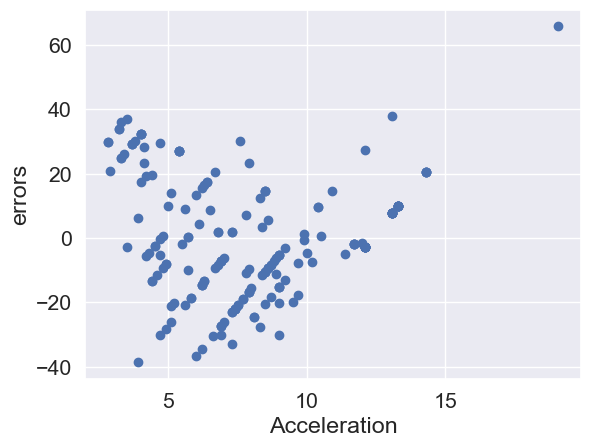

In [44]:
x = np.array(df_ev['Acceleration']).reshape(-1, 1)
y = np.array(df_ev['Top Speed'])

reg = LinearRegression()

reg.fit(x, y) 

y_pred = reg.predict(x)

errors = y - y_pred

plt.scatter(x = x, y = errors)
plt.xlabel('Acceleration')
plt.ylabel('errors');

Because of this, we might see if Polynomial Regression is more appropriate:

LinearRegression(fit_intercept=False)

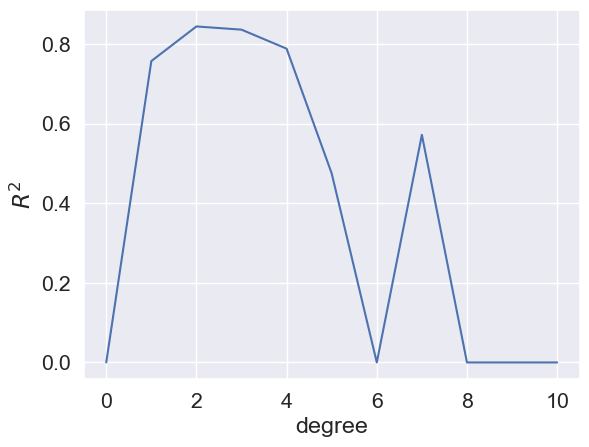

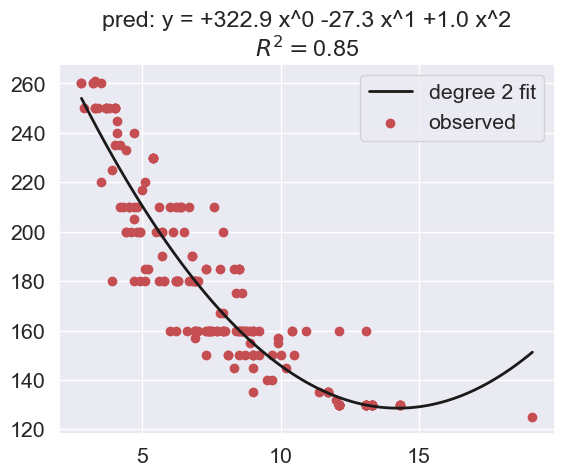

In [45]:
# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(11):
    r2 = cross_val_r2(x, y, degree)
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)

plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')

plt.figure()
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(x, y, degree_best)

We can get errors the same way with a polynomial fit, and check to see that the pattern we saw in the error plot is gone (i.e. that we've "fixed" the constant variance assumption:

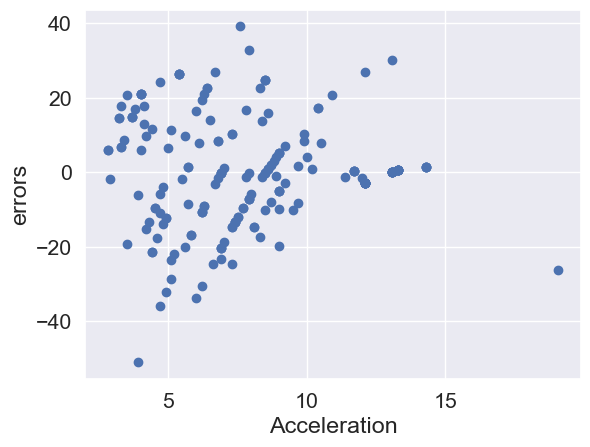

In [46]:
# project x to polynomial (degree 2 seems best from above)
poly_project = PolynomialFeatures(degree=2)
x_poly = poly_project.fit_transform(x)
    
# fit via linear regression
reg = LinearRegression(fit_intercept=False)
reg.fit(x_poly, y)

y_pred = reg.predict(x_poly)

errors = y - y_pred

plt.scatter(x = x, y = errors)
plt.xlabel('Acceleration')
plt.ylabel('errors');

# Lecture Break/Practice 2

For the `hank_aaron_hr.csv` dataset
1. regress `age` & `HRR`
    - this gives baseball player Hank Aarons Home Run Rate over his career by age
1. use cross validation to find the best polynomial fit for the model (test degree `0` through `10`)
    - use `n_splits=23` (this will use each point as its own fold; a reasonable approach when you have a very small data set)
1. plot the best fit line over the points for that polynomial fit of all the data and calculate the $R^2$
1. check the assumptions (independence, constant variance, and normality)

In [47]:
df_aaron = pd.read_csv('hank_aaron_hr.csv')
df_aaron.head()

,Unnamed: 0,playerID,age,AB,HR,HRR
0,10,aaronha01,26,590,40,0.067797
1,11,aaronha01,31,570,32,0.056140
2,12,aaronha01,20,468,13,0.027778
3,13,aaronha01,27,603,34,0.056385
4,14,aaronha01,34,606,29,0.047855
